# Mountain Car
### Pierpaolo Spaziani - 0316331

#### Description

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction.\
The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

#### Observation Space

| Name | Dimension | Description |
|----------------|:-----------:|-------------------------------------------------|
| Action Space | 3 | Discrete actions: **0** (*push left*), **1** (*no push*), **2** (*push right*). |
| Observation Space | 2 | Continuous values representing position and velocity of the car. **Position**: [-1.2, 0.6], **Velocity**: [-0.07 0.07]|

#### Reward

The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

#### Starting State

The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.

#### Episode End

The episode ends if either of the following happens:

- Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
- Truncation: The length of the episode is 200.

#### Objective

The objective of this notebook is to solve the problem and compare the results of 2 models:
- **Q-Learning**
- **Sarsa**

<u>**NOTE**</u>: *gym* version 0.26.2 is required to run the code

In [1]:
import gym
import numpy as np
import imageio
import random
import math
import pickle
import matplotlib.pyplot as plt

# In the gym library there is a deprecation about NumPy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="gym.utils.passive_env_checker")

env = gym.make("MountainCar-v0")

### Discretization
In the presence of *continuous states* it is convenient to **discretize** for several reasons:
- Limit the *state-action* space
- Memory management
- Faster training

Cons:
- The ***discretization size*** is an hyper-parameter

In [2]:
def get_discrete_state(state):
    chunk_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_SIZE
    discrete_state = (state - env.observation_space.low) / chunk_size
    return tuple(discrete_state.astype(int))

### Decay functions

Implementation of decay functions used for ***Learning Rate*** and ***Epsilon***:
- *linear decay*
- *exponential decay*

In [3]:
def decay(episode, type, actual_value, max_value, min_value, fraction_decay):
    if type == 'linear' and actual_value > min_value:
        actual_value = linear_decay(actual_value, max_value, fraction_decay)
    elif type == 'exponential' and actual_value > min_value:
        actual_value = exponential_decay(episode, max_value, fraction_decay)
    return actual_value

def linear_decay(actual_value, max_value, fraction_decay):
    decay_rate = max_value / (EPISODES * fraction_decay)
    new_value = actual_value - decay_rate
    return max(0, new_value)

def exponential_decay(episode, max_value, fraction_decay):
    alpha = -math.log(0.01) / (EPISODES * fraction_decay)
    new_value = max_value * math.exp(-alpha * episode)
    return max(0, new_value)

### ε-Greedy

Implementation of the **ε-Greedy** policy for *exploration-exploitation trade-off*:

In [4]:
def epsilon_greedy(epsilon):
    if random.uniform(0, 1) < epsilon:
        # takes a random action
        return random.choice(range(env.action_space.n))
    else:
        # takes the "best" action
        return -1

### Output class

Declaration of a standard output class:

In [5]:
class Output:
    def __init__(self, victory_history, learning_rate_history, epsilon_history, q_table, states_history_table, reward_history):
        self.victory_history = victory_history
        self.learning_rate_history = learning_rate_history
        self.epsilon_history = epsilon_history
        self.q_table = q_table
        self.states_history_table = states_history_table
        self.reward_history = reward_history

## Q-Learning

#### Algorithm
t ← 0\
Initialize Q (e.g., zero-initialized)\
Loop:\
$\;\;\;$|$\;\;\;$ choose action $a_t$ based on ε-greedy or softmax policy\
$\;\;\;$|$\;\;\;$ observe next state $s_{t+1}$ and reward $r_t$\
$\;\;\;$|$\;\;\;$ $Q(s_t, a_t) ← Q(s_t, a_t) + α_t \cdot [r_t + γ \cdot max_{a' ∈ A} Q(s_{t+1}, a') - Q(s_t, a_t)]$\
$\;\;\;$|$\;\;\;$ t ← t + 1\
EndLoop

#### Implementation

In [6]:
def q_learning():
    # initialization of the Q-table
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))
    
    # initialization of parameters
    learning_rate = MAX_LEARNING_RATE
    epsilon = MAX_EPSILON
    victories = 0
    victory_history = []
    learning_rate_history = []
    epsilon_history = []
    states_history_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE))
    reward_history = []

    # loop through episodes
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        # initialize the sum of reward gained during the current episode
        reward_sum = 0

        # reset the environment
        env.reset()

        # get the discrete representation of the current state
        discrete_state = get_discrete_state(env.state)

        states_history_table[discrete_state] = states_history_table[discrete_state] + 1

        # decay the learning rate and epsilon
        learning_rate = decay(episode, LEARNING_RATE_DECAY, learning_rate, MAX_LEARNING_RATE, MIN_LEARNING_RATE, LEARNING_RATE_FRACTION_DECAY)
        epsilon = decay(episode, EPSILON_DECAY, epsilon, MAX_EPSILON, MIN_EPSILON, EPSILON_FRACTION_DECAY)
        learning_rate_history.append(learning_rate)
        epsilon_history.append(epsilon)

        lenght = 0
        done = False
        while not done:

            # increases the duration of the episode
            lenght += 1
        
            # select an action following the epsilon-greedy policy
            action = epsilon_greedy(epsilon)
            if action < 0:
                action = np.argmax(q_table[discrete_state])

            # execute the action
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # update the reward sum
            reward_sum = reward_sum + reward

            states_history_table[new_discrete_state] = states_history_table[new_discrete_state] + 1
        
            done = terminated or truncated
            if not done:
                # update the current Q-value using the Q-learning algorithm
                max_future_q = np.max(q_table[new_discrete_state])
                current_q = q_table[discrete_state + (action, )]
                new_q = current_q + learning_rate * (reward + DISCOUNT * max_future_q - current_q)
                q_table[discrete_state + (action, )] = new_q
            elif terminated:
                # if the episode ended successfully
                victories = victories + 1
                current_q = q_table[discrete_state + (action, )]
                new_q = current_q + learning_rate * (reward - current_q)
                q_table[discrete_state + (action, )] = new_q
            
            # move to the new state
            discrete_state = new_discrete_state

        # add the sum of reward gained to the reward history list
        reward_history.append(reward_sum)
            
        # update the victory history list
        victory_history.append(victories)
    
    env.close()
    return Output(victory_history, learning_rate_history, epsilon_history, q_table, states_history_table, reward_history)

## SARSA

#### Algorithm

t ← 0\
Initialize Q (e.g., zero-initialized)\
choose $a_t$ (e.g., ε-greedy or softmax selection)\
Loop:\
$\;\;\;$|$\;\;\;$ observe next state $s_{t+1}$ and reward $r_t$\
$\;\;\;$|$\;\;\;$ choose $a_{t+1}$ (e.g., ε-greedy or softmax selection)\
$\;\;\;$|$\;\;\;$ observe next state $s_{t+1}$ and reward $r_t$\
$\;\;\;$|$\;\;\;$ $Q(s_t, a_t) ← Q(s_t, a_t) + α_t \cdot [r_t + γ \cdot Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]$\
$\;\;\;$|$\;\;\;$ t ← t + 1\
EndLoop

#### Implementation

In [7]:
def SARSA():
    # initialization of the Q-table
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))

    # initialization of parameters
    learning_rate = MAX_LEARNING_RATE
    epsilon = MAX_EPSILON
    victories = 0
    victory_history = []
    learning_rate_history = []
    epsilon_history = []
    states_history_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE))
    reward_history = []
    
    # loop through episodes
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        # initialize the sum of reward gained during the current episode
        reward_sum = 0

        # reset the environment
        env.reset()

        # get the discrete representation of the current state
        discrete_state = get_discrete_state(env.state)

        states_history_table[discrete_state] = states_history_table[discrete_state] + 1

        # decay the learning rate and epsilon
        learning_rate = decay(episode, LEARNING_RATE_DECAY, learning_rate, MAX_LEARNING_RATE, MIN_LEARNING_RATE, LEARNING_RATE_FRACTION_DECAY)
        epsilon = decay(episode, EPSILON_DECAY, epsilon, MAX_EPSILON, MIN_EPSILON, EPSILON_FRACTION_DECAY)
        learning_rate_history.append(learning_rate)
        epsilon_history.append(epsilon)
        
        # select an action following the epsilon-greedy policy
        action = epsilon_greedy(epsilon)
        if action < 0:
            action = np.argmax(q_table[discrete_state])

        lenght = 0
        done = False
        while not done:

            # increases the duration of the episode
            lenght += 1

            # execute the action
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # update the reward sum
            reward_sum = reward_sum + reward

            states_history_table[new_discrete_state] = states_history_table[new_discrete_state] + 1

            # select a new action following the epsilon-greedy policy
            new_action = epsilon_greedy(epsilon)
            if new_action < 0:
                new_action = np.argmax(q_table[new_discrete_state])
        
            done = terminated or truncated
            if not done:
                # update the current Q-value using the SARSA algorithm
                new_q = q_table[new_discrete_state + (new_action, )]
                current_q = q_table[discrete_state + (action, )]
                updated_q = current_q + learning_rate * (reward + DISCOUNT * new_q - current_q)
                q_table[discrete_state + (action, )] = updated_q
            elif terminated:
                # if the episode ended successfully
                victories = victories + 1
                current_q = q_table[discrete_state + (action, )]
                updated_q = current_q + learning_rate * (reward - current_q)
                q_table[discrete_state + (action, )] = updated_q
            
            # move to the new state
            discrete_state = new_discrete_state

            # set the action for next step
            action = new_action

        # add the sum of reward gained to the reward history list
        reward_history.append(reward_sum)

        # update the victory history list
        victory_history.append(victories)
    
    env.close()
    return Output(victory_history, learning_rate_history, epsilon_history, q_table, states_history_table, reward_history)

***
# Simulation

In [8]:
# Since the runs are long it is convenient to save the output values in external files ...
def save_output(output, file):
    with open(file, 'wb') as f:
        pickle.dump(output, f)

# ... and load them when needed
def load_output(file):
    with open(file, 'rb') as f:
        output = pickle.load(f)
    return output

### Tuning *LEARNING_RATE* & *EPSILON* 

For both values, performance was evaluated with different combinations:
- Decay:
  - Linear (**L**)
  - Exponential (**E**)
- Decay Fraction:
  - 1/4
  - 2/3
 
<u>**NOTE**</u>: The values in the legend refer respectively to:
- LEARNING_RATE_DECAY
- EPSILON_DECAY
- LEARNING_RATE_FRACTION_DECAY
- EPSILON_FRACTION_DECAY

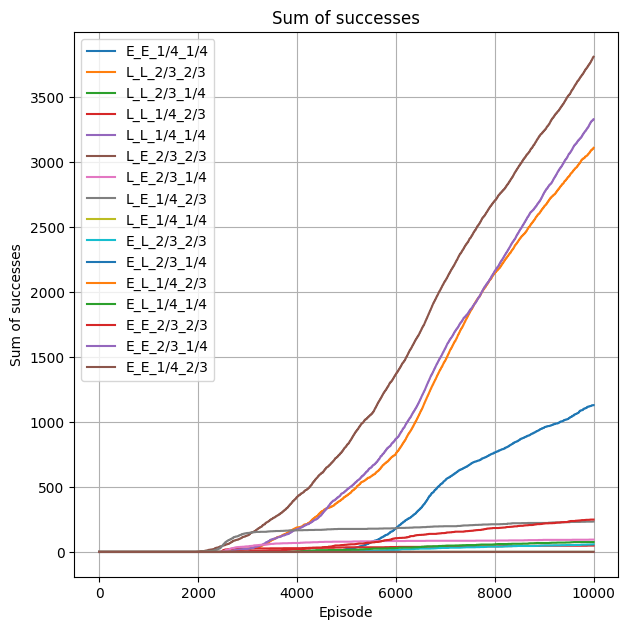

The best configuration is: L_E_2/3_2/3


In [21]:
TUNING = False
TUNING_GRAPH = False

MAX_LEARNING_RATE = 1
MIN_LEARNING_RATE = 0.01

MAX_EPSILON = 1
MIN_EPSILON = 0

DISCOUNT = 0.95

decay_list = ['linear', 'exponential']
faction_list = [2/3, 1/4]

EPISODES = 10000

DISCRETE_SIZE = 100

if TUNING:
    q_learning_output = []
    for LEARNING_RATE_DECAY in decay_list:
        for EPSILON_DECAY in decay_list:
            for LEARNING_RATE_FRACTION_DECAY in faction_list:
                for EPSILON_FRACTION_DECAY in faction_list:
                    q_learning_output.append(q_learning())
    save_output(q_learning_output, 'saved_data/tuning_lr_eps/q_learning_output.pkl')

if TUNING_GRAPH:
    name = 'saved_data/tuning_lr_eps/q_learning_output.pkl'
    q_learning_output = load_output(name)
    
    decay_list = ['L', 'E']
    faction_list = ['2/3', '1/4']
    names = []
    for LEARNING_RATE_DECAY in decay_list:
        for EPSILON_DECAY in decay_list:
            for LEARNING_RATE_FRACTION_DECAY in faction_list:
                for EPSILON_FRACTION_DECAY in faction_list:
                    names.append(LEARNING_RATE_DECAY+'_'+EPSILON_DECAY+'_'+LEARNING_RATE_FRACTION_DECAY+'_'+EPSILON_FRACTION_DECAY)
                    
    plt.figure(figsize=(12, 12))
    plt.subplot2grid((4, 2), (0, 0), rowspan=2, colspan=1)
    for output in q_learning_output:
        plt.plot(output.victory_history, label=names[q_learning_output.index(output)-1])
    plt.xlabel('Episode')
    plt.ylabel('Sum of successes')
    plt.title('Sum of successes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    max_line = max(q_learning_output, key=lambda output: max(output.victory_history))
    max_line_index = q_learning_output.index(max_line)
    print(f"The best configuration is: {names[max_line_index-1]}")

### Tuning *DISCRETE_SIZE*
In this section we will evaluate the performance by varying ***DISCRETE_SIZE*** with the values obtained in the previous step for *LEARNING_RATE* and *EPSILON*:

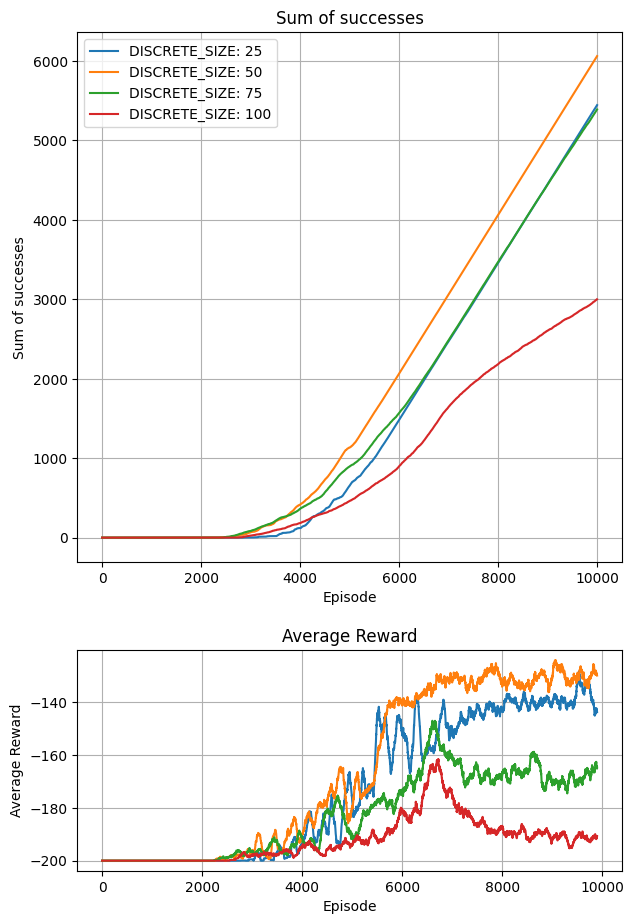

In [22]:
TUNING = False
TUNING_GRAPH = False

MAX_LEARNING_RATE = 1
MIN_LEARNING_RATE = 0.01

MAX_EPSILON = 1
MIN_EPSILON = 0

DISCOUNT = 0.95

# DECAY POSSIBLE VALUES:
# no_decay - linear - exponential
LEARNING_RATE_DECAY = 'linear'
EPSILON_DECAY = 'exponential'

# indicates the percentage of the episode in which LEARNING_RATE and EPSILON decay, after which they will remain fixed at the minimum value
LEARNING_RATE_FRACTION_DECAY = 2/3
EPSILON_FRACTION_DECAY = 2/3

EPISODES = 15000

discrete_size_list = [25, 50, 75, 100]

if TUNING:
    q_learning_output = []
    for DISCRETE_SIZE in discrete_size_list:
        q_learning_output.append(q_learning())
    save_output(q_learning_output, 'saved_data/tuning_ds/q_learning_output.pkl')

if TUNING_GRAPH:
    name = 'saved_data/tuning_ds/q_learning_output.pkl'
    q_learning_output = load_output(name)

    plt.figure(figsize=(12, 12))
    
    plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
    for output in q_learning_output:
        ds_index = q_learning_output.index(output)
        label = "DISCRETE_SIZE: " + str(discrete_size_list[ds_index])
        plt.plot(output.victory_history, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Sum of successes')
    plt.title('Sum of successes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.subplot2grid((4, 4), (2, 0), rowspan=1, colspan=2)
    for output in q_learning_output:
        ds_index = q_learning_output.index(output)
        label = "DISCRETE_SIZE: " + str(discrete_size_list[ds_index])
        q_learning_rewards_avg = np.convolve(output.reward_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(q_learning_rewards_avg, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward')
    plt.grid(True)

    plt.subplots_adjust(hspace=0.4)

    plt.show()

***
### Parameters & Hyper-Parameters Setting

For a better comparison between models, the following Parameters and Hyper-Parameters are common among algorithm simulations.

Suggested value pairs for *EPISODES* and *DISCRETE_SIZE* (based on previous tuning) are:

|    EPISODES    | DISCRETE_SIZE |   Description   |
|:--------------:|:-------------:|:---------------:|
|      5000      |       25      | Fast but edgy   |
|     10000      |       50      | Fast and smooth |
|     15000      |      100      | Slow but smooth |

In [24]:
MAX_LEARNING_RATE = 1
MIN_LEARNING_RATE = 0.01

MAX_EPSILON = 1
MIN_EPSILON = 0

DISCOUNT = 0.95

# DECAY POSSIBLE VALUES:
# no_decay - linear - exponential
LEARNING_RATE_DECAY = 'linear'
EPSILON_DECAY = 'exponential'

# indicates the percentage of the episode in which LEARNING_RATE and EPSILON decay, after which they will remain fixed at the minimum value
LEARNING_RATE_FRACTION_DECAY = 2/3
EPSILON_FRACTION_DECAY = 2/3

EPISODES = 10000

DISCRETE_SIZE = 50

### Q-Learning simulation

In [66]:
q_learning_output = q_learning()
print("There were", q_learning_output.victory_history[-1], "successes!")

There were 2673 successes!


### SARSA simulation

In [67]:
sarsa_output = SARSA()
print("There were", sarsa_output.victory_history[-1], "successes!")

There were 3223 successes!


### Results

As expected, **SARSA** converges faster than **Q-Learning** even if the *average rewards* then tend to stabilize around the same range of values.

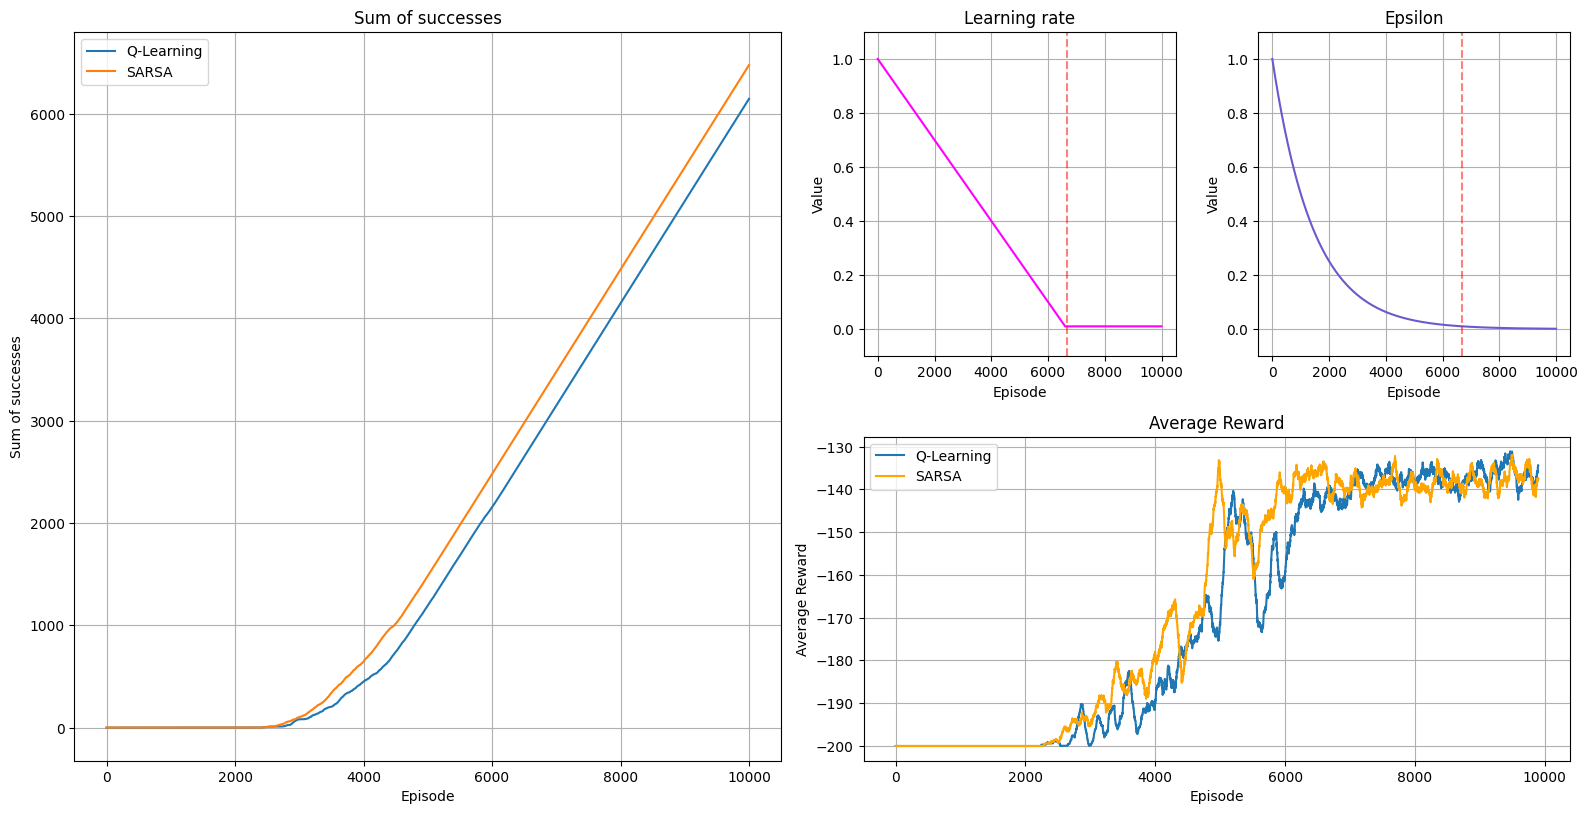

In [25]:
# Plot results

window_size = 100

plt.figure(figsize=(16, 24))

plt.subplot2grid((6, 4), (0, 0), rowspan=2, colspan=2)
plt.plot(q_learning_output.victory_history, label='Q-Learning')
plt.plot(sarsa_output.victory_history, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Sum of successes')
plt.title('Sum of successes')
plt.legend()
plt.grid(True)

plt.subplot2grid((6, 4), (0, 2), rowspan=1, colspan=1)
plt.plot(sarsa_output.learning_rate_history, color='magenta')
plt.axvline(x=EPISODES*LEARNING_RATE_FRACTION_DECAY, color='red', linestyle='--', alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Learning rate')
plt.grid(True)

plt.subplot2grid((6, 4), (0, 3), rowspan=1, colspan=1)
plt.plot(sarsa_output.epsilon_history, color='slateblue')
plt.axvline(x=EPISODES*EPSILON_FRACTION_DECAY, color='red', linestyle='--', alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Epsilon')
plt.grid(True)

plt.subplot2grid((6, 4), (1, 2), rowspan=1, colspan=3)
q_learning_rewards_avg = np.convolve(q_learning_output.reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(q_learning_rewards_avg, label='Q-Learning')
q_learning_rewards_avg = np.convolve(sarsa_output.reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(q_learning_rewards_avg, color='orange', label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

### Q-Value & Policy Analysis

All 3 graphs are similar pairwise, the only difference is that the **SARSA** graphs are slightly more precise.

As is evident from the ***Q-Value graphs***, the outermost states are not affected (*Q-value = 0*).
This highlights how ***model-free*** algorithms avoid learning "useless" things (in this case states we would never have visited).

From the ***Policy graphs*** an "intuitive" behavior can be seen, i.e. if I go right (*positive speed*) I continue to go right, if I go left (*negative speed*) I continue to go left or I don't accelerate.

By observing the ***State History graphs***, we can observe how there are 2 paths that can lead to the goal. The discovery of more than 1 path can be explained by the fact that the starting position in each episode is random in the range [-0.6, -0.4] and that therefore the agent could start in a non-optimal state for a given path.

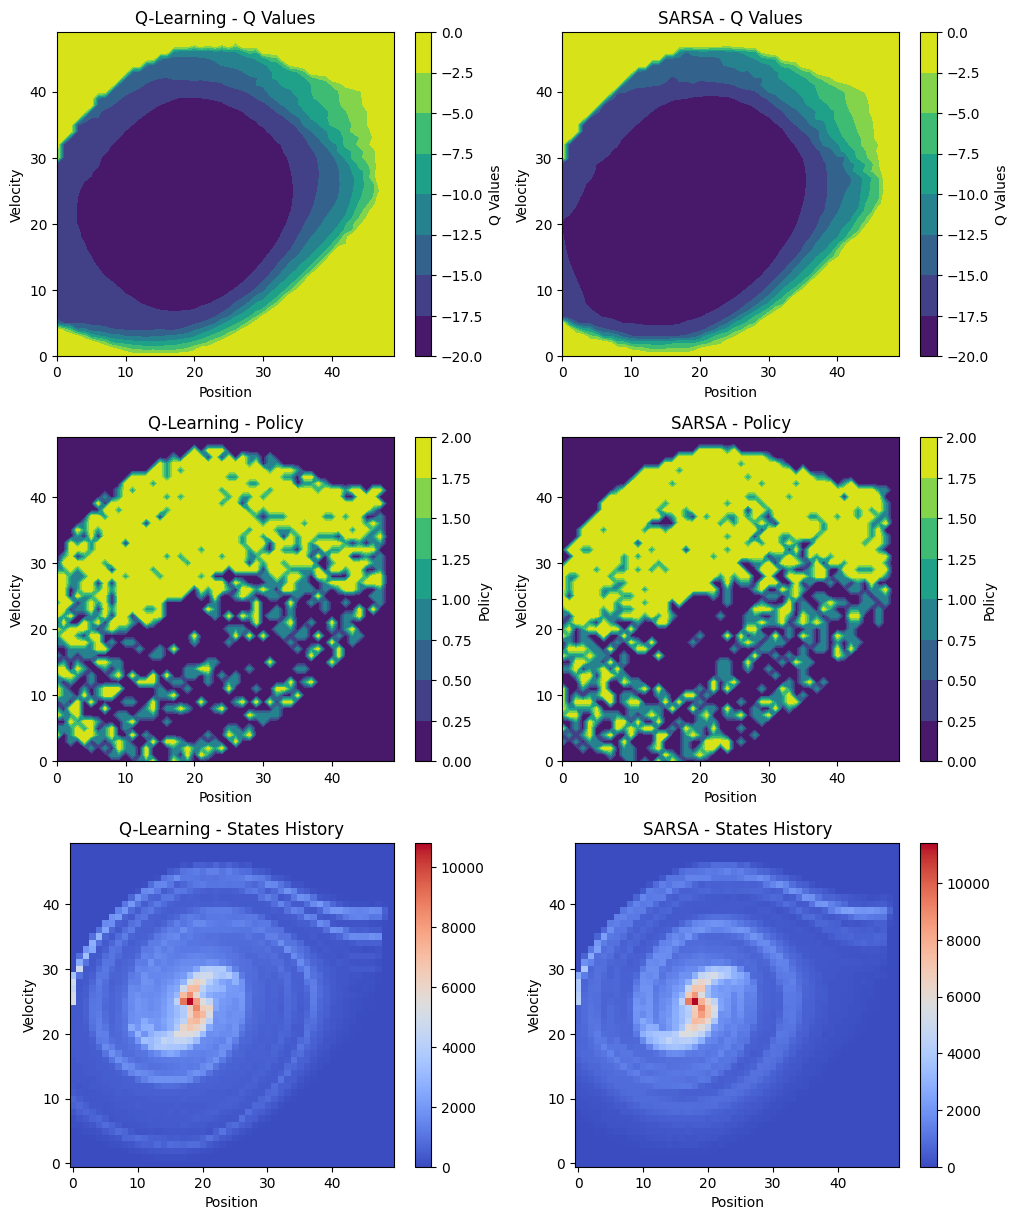

In [26]:
# Plot Q-Value & Policy

plt.figure(figsize=(25, 20))

# Q-Learning - Q Values
plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=1)
q_learning_q_values_plot = plt.contourf(np.transpose(q_learning_output.q_table[:, :, 2]))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - Q Values')
plt.colorbar(q_learning_q_values_plot, ax=plt.gca(), label='Q Values')

# Q-Learning - Policy
plt.subplot2grid((4, 4), (1, 0), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.transpose(np.argmax(q_learning_output.q_table, axis=2)))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# SARSA - Q Values
plt.subplot2grid((4, 4), (0, 1), rowspan=1, colspan=1)
sarsa_q_values_plot = plt.contourf(np.transpose(sarsa_output.q_table[:, :, 2]))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - Q Values')
plt.colorbar(sarsa_q_values_plot, ax=plt.gca(), label='Q Values')

# SARSA - Policy
plt.subplot2grid((4, 4), (1, 1), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.transpose(np.argmax(sarsa_output.q_table, axis=2)))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# Q-Learning - States History
plt.subplot2grid((4, 4), (2, 0), rowspan=1, colspan=1)
plt.imshow(np.transpose(q_learning_output.states_history_table), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - States History')
plt.gca().invert_yaxis()

# SARSA - States History
plt.subplot2grid((4, 4), (2, 1), rowspan=1, colspan=1)
plt.imshow(np.transpose(sarsa_output.states_history_table), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - States History')
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.25)

plt.show()

## Smoother Policy

As is also evident from the previous graphs, with this reward system, **Q-Learning** and **SARSA** model a *"dotted" policy*.\
If we wanted a smoother policy, it is possible to make a change to the reward system by introducing a penalty in the event of a change of action.\
This will lead the model to change action only if necessary. Intuitively:
- If we are going up we want to continue moving in that direction until we stop.
- If we are going down we want to keep moving in that direction to gain more speed.

So we set that if the agent chooses an action different from the previous one, the reward for that step is decreased by 1 additionally.

In [116]:
def updated_q_learning():
    # initialization of the Q-table
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))
    
    # initialization of parameters
    learning_rate = MAX_LEARNING_RATE
    epsilon = MAX_EPSILON
    victories = 0
    victory_history = []
    learning_rate_history = []
    epsilon_history = []
    states_history_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE))
    reward_history = []

    # loop through episodes
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        # initialize the sum of reward gained during the current episode
        reward_sum = 0

        # reset the environment
        env.reset()

        # get the discrete representation of the current state
        discrete_state = get_discrete_state(env.state)

        states_history_table[discrete_state] = states_history_table[discrete_state] + 1

        # decay the learning rate and epsilon
        learning_rate = decay(episode, LEARNING_RATE_DECAY, learning_rate, MAX_LEARNING_RATE, MIN_LEARNING_RATE, LEARNING_RATE_FRACTION_DECAY)
        epsilon = decay(episode, EPSILON_DECAY, epsilon, MAX_EPSILON, MIN_EPSILON, EPSILON_FRACTION_DECAY)
        learning_rate_history.append(learning_rate)
        epsilon_history.append(epsilon)

        # records the previous action
        last_action = 1
    
        lenght = 0
        done = False
        while not done:

            # increases the duration of the episode
            lenght += 1
        
            # select an action following the epsilon-greedy policy
            action = epsilon_greedy(epsilon)
            if action < 0:
                action = np.argmax(q_table[discrete_state])

            # execute the action
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # penalize if the action is different from the previous one
            if last_action != action:
                reward += -1

            # update the reward sum
            reward_sum = reward_sum + reward

            states_history_table[new_discrete_state] = states_history_table[new_discrete_state] + 1
        
            done = terminated or truncated
            if not done:
                # update the current Q-value using the Q-learning algorithm
                max_future_q = np.max(q_table[new_discrete_state])
                current_q = q_table[discrete_state + (action, )]
                new_q = current_q + learning_rate * (reward + DISCOUNT * max_future_q - current_q)
                q_table[discrete_state + (action, )] = new_q
            elif terminated:
                # if the episode ended successfully
                victories = victories + 1
                q_table[discrete_state + (action, )] = 0
            
            # move to the new state
            discrete_state = new_discrete_state

            # update last action
            last_action = action

        # add the sum of reward gained to the reward history list
        reward_history.append(reward_sum)
            
        # update the victory history list
        victory_history.append(victories)
    
    env.close()
    return Output(victory_history, learning_rate_history, epsilon_history, q_table, states_history_table, reward_history)

In [117]:
def updated_SARSA():
    # initialization of the Q-table
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))

    # initialization of parameters
    learning_rate = MAX_LEARNING_RATE
    epsilon = MAX_EPSILON
    victories = 0
    victory_history = []
    learning_rate_history = []
    epsilon_history = []
    states_history = []
    states_history_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE))
    reward_history = []
    
    # loop through episodes
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        # initialize the sum of reward gained during the current episode
        reward_sum = 0

        # reset the environment
        env.reset()

        # get the discrete representation of the current state
        discrete_state = get_discrete_state(env.state)

        states_history_table[discrete_state] = states_history_table[discrete_state] + 1

        # decay the learning rate and epsilon
        learning_rate = decay(episode, LEARNING_RATE_DECAY, learning_rate, MAX_LEARNING_RATE, MIN_LEARNING_RATE, LEARNING_RATE_FRACTION_DECAY)
        epsilon = decay(episode, EPSILON_DECAY, epsilon, MAX_EPSILON, MIN_EPSILON, EPSILON_FRACTION_DECAY)
        learning_rate_history.append(learning_rate)
        epsilon_history.append(epsilon)
        
        # select an action following the epsilon-greedy policy
        action = epsilon_greedy(epsilon)
        if action < 0:
            action = np.argmax(q_table[discrete_state])

        # records the previous action
        last_action = 1

        lenght = 0
        done = False
        while not done:

            # increases the duration of the episode
            lenght += 1

            # execute the action
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # penalize if the action is different from the previous one
            if last_action != action:
                reward += -1

            # update the reward sum
            reward_sum = reward_sum + reward

            states_history_table[new_discrete_state] = states_history_table[new_discrete_state] + 1

            # select a new action following the epsilon-greedy policy
            new_action = epsilon_greedy(epsilon)
            if new_action < 0:
                new_action = np.argmax(q_table[new_discrete_state])
        
            done = terminated or truncated
            if not done:
                # update the current Q-value using the SARSA algorithm
                new_q = q_table[new_discrete_state + (new_action, )]
                current_q = q_table[discrete_state + (action, )]
                updated_q = current_q + learning_rate * (reward + DISCOUNT * new_q - current_q)
                q_table[discrete_state + (action, )] = updated_q
            elif terminated:
                # if the episode ended successfully
                victories = victories + 1
                q_table[discrete_state + (action, )] = 0
            
            # move to the new state
            discrete_state = new_discrete_state

            # update last action
            last_action = action

            # set the action for next step
            action = new_action

        # add the sum of reward gained to the reward history list
        reward_history.append(reward_sum)

        # update the victory history list
        victory_history.append(victories)
    
    env.close()
    return Output(victory_history, learning_rate_history, epsilon_history, q_table, states_history_table, reward_history)

### Updated Q-Learning simulation

In [118]:
updated_q_learning_output = updated_q_learning()
print("There were", updated_q_learning_output.victory_history[-1], "successes!")

There were 3428 successes!


### Updated SARSA simulation

In [119]:
updated_sarsa_output = updated_SARSA()
print("There were", updated_sarsa_output.victory_history[-1], "successes!")

There were 3632 successes!


### Results

**Updated Q-Learning** surpasses all the others both in terms of convergence and stabilizes on the same range of values for the *average reward*.

On the contrary, **Updated SARSA** turns out to be the worst of all!\
One possible explanation is that SARSA, being an ***on-policy*** algorithm, takes currently chosen actions into account when estimating the Q function. This may lead it to be more cautious in exploring new actions because it would be penalized more. This is evident in the *State History graph* where there are clear lines with no "shadow" around them.

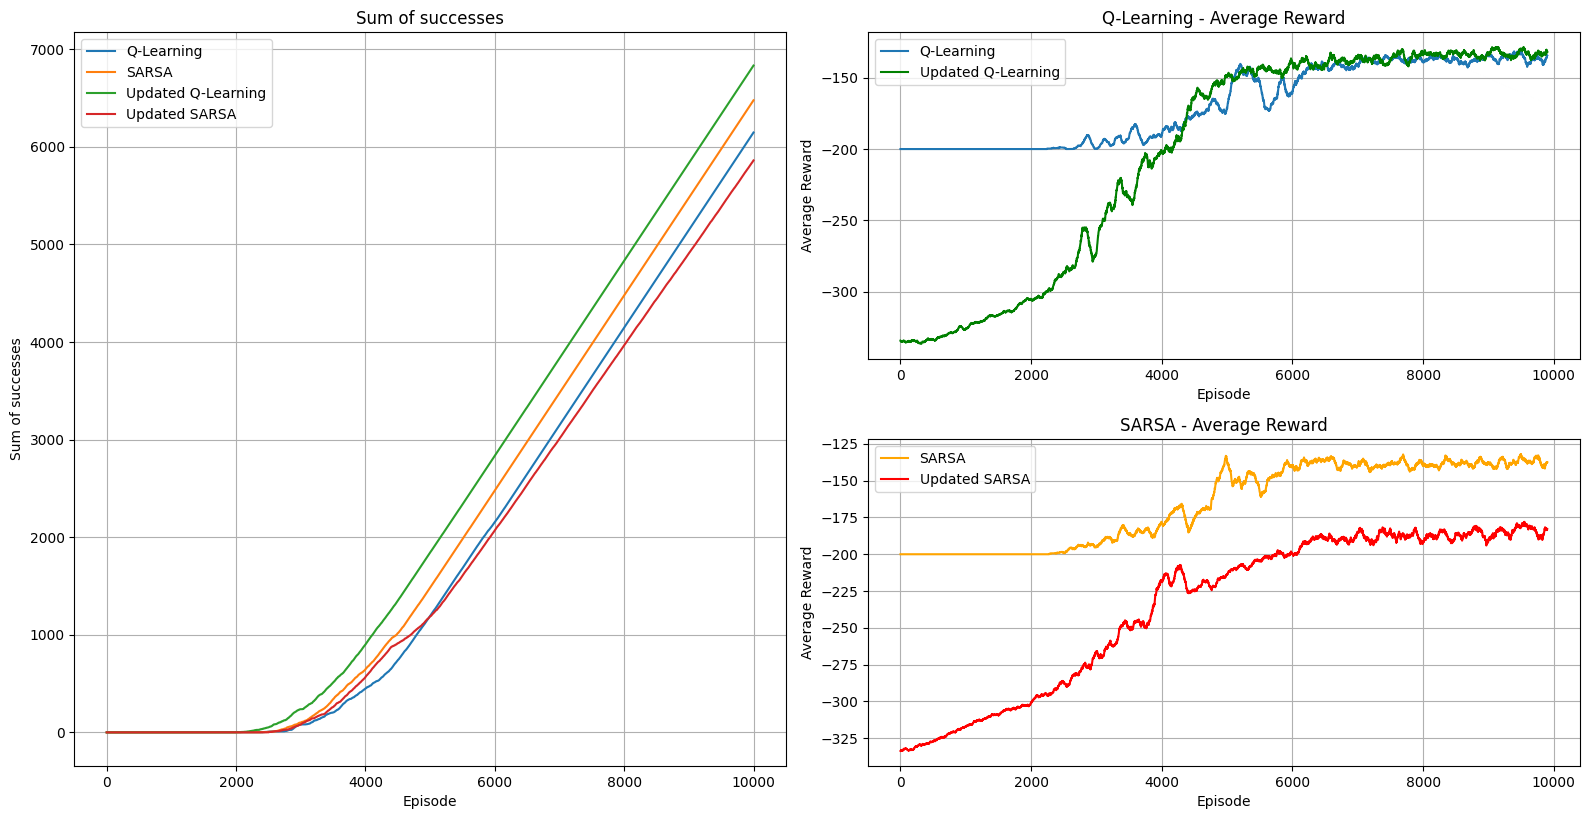

In [27]:
# Plot results

window_size = 100

plt.figure(figsize=(16, 16))

plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
plt.plot(q_learning_output.victory_history, label='Q-Learning')
plt.plot(sarsa_output.victory_history, label='SARSA')
plt.plot(updated_q_learning_output.victory_history, label='Updated Q-Learning')
plt.plot(updated_sarsa_output.victory_history, label='Updated SARSA')
plt.xlabel('Episode')
plt.ylabel('Sum of successes')
plt.title('Sum of successes')
plt.legend()
plt.grid(True)

plt.subplot2grid((4, 4), (0, 2), rowspan=1, colspan=2)
q_learning_rewards_avg = np.convolve(q_learning_output.reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(q_learning_rewards_avg, label='Q-Learning')
q_learning_rewards_avg = np.convolve(updated_q_learning_output.reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(q_learning_rewards_avg, label='Updated Q-Learning', color='green')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-Learning - Average Reward')
plt.legend()
plt.grid(True)

plt.subplot2grid((4, 4), (1, 2), rowspan=1, colspan=2)
q_learning_rewards_avg = np.convolve(sarsa_output.reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(q_learning_rewards_avg, label='SARSA', color='orange')
q_learning_rewards_avg = np.convolve(updated_sarsa_output.reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(q_learning_rewards_avg, label='Updated SARSA', color='red')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('SARSA - Average Reward')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

### Q-Value & Policy Analysis

Also in this case the two models (the updated ones) tend to behave in the same way, but in **Q-Learning** preferred paths are more evident.

The ***Q-Value graphs*** are obviously deeper compared to the basic models, but this leads to better specialization (which we wanted in this case but generally don't like).

The ***Policy graphs*** are more defined for the behavior we wanted. Having spent multiple episodes on the optimal paths, the other areas of the policy remained dirty having rarely passed there.

In the ***State History graphs*** the two curves are much more evident, which means that the paths leading to the goal have been taken several times.

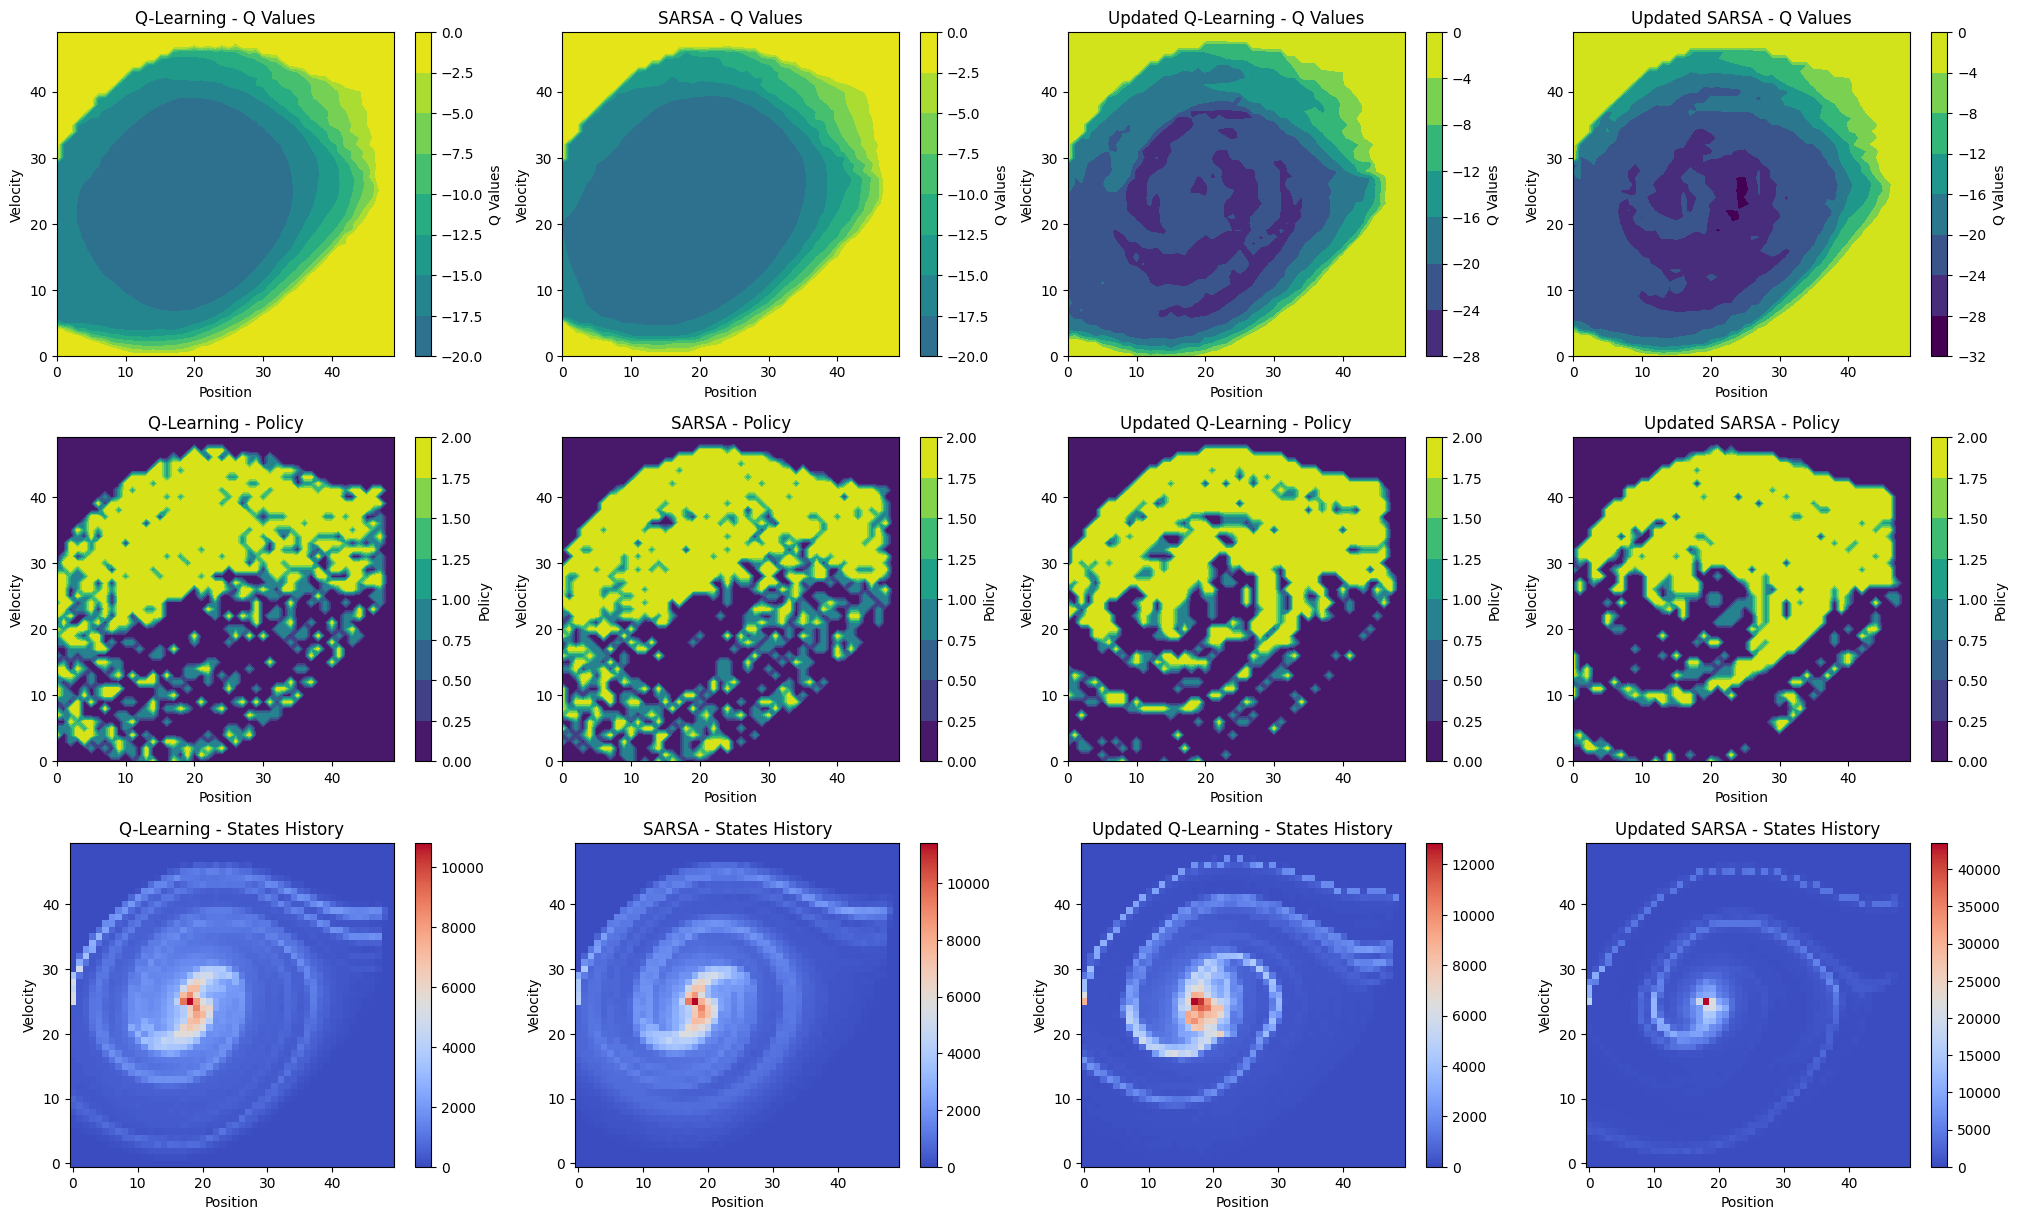

In [28]:
# Compare models

plt.figure(figsize=(25, 20))

min_value = min(np.min(updated_q_learning_output.q_table[:, :, 2]), np.min(q_learning_output.q_table[:, :, 2]), np.min(sarsa_output.q_table[:, :, 2]), np.min(updated_sarsa_output.q_table[:, :, 2]))
max_value = max(np.max(updated_q_learning_output.q_table[:, :, 2]), np.max(q_learning_output.q_table[:, :, 2]), np.max(sarsa_output.q_table[:, :, 2]), np.max(updated_sarsa_output.q_table[:, :, 2]))

# Q-Learning - Q Values
plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=1)
q_learning_q_values_plot = plt.contourf(np.transpose(q_learning_output.q_table[:, :, 2]), vmin=min_value, vmax=max_value)
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - Q Values')
plt.colorbar(q_learning_q_values_plot, ax=plt.gca(), label='Q Values')

# Q-Learning - Policy
plt.subplot2grid((4, 4), (1, 0), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.transpose(np.argmax(q_learning_output.q_table, axis=2)))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# SARSA - Q Values
plt.subplot2grid((4, 4), (0, 1), rowspan=1, colspan=1)
sarsa_q_values_plot = plt.contourf(np.transpose(sarsa_output.q_table[:, :, 2]), vmin=min_value, vmax=max_value)
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - Q Values')
plt.colorbar(sarsa_q_values_plot, ax=plt.gca(), label='Q Values')

# SARSA - Policy
plt.subplot2grid((4, 4), (1, 1), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.transpose(np.argmax(sarsa_output.q_table, axis=2)))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# Q-Learning - States History
plt.subplot2grid((4, 4), (2, 0), rowspan=1, colspan=1)
plt.imshow(np.transpose(q_learning_output.states_history_table), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - States History')
plt.gca().invert_yaxis()

# SARSA - States History
plt.subplot2grid((4, 4), (2, 1), rowspan=1, colspan=1)
plt.imshow(np.transpose(sarsa_output.states_history_table), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - States History')
plt.gca().invert_yaxis()

# -------------------------------------------------------------------------------------------

# Updated Q-Learning - Q Values
plt.subplot2grid((4, 4), (0, 2), rowspan=1, colspan=1)
q_learning_q_values_plot_transposed = plt.contourf(np.transpose(updated_q_learning_output.q_table[:, :, 2]), vmin=min_value, vmax=max_value)
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Updated Q-Learning - Q Values')
plt.colorbar(q_learning_q_values_plot_transposed, ax=plt.gca(), label='Q Values')

# Updated Q-Learning - Policy
plt.subplot2grid((4, 4), (1, 2), rowspan=1, colspan=1)
sarsa_policy_plot_transposed = plt.contourf(np.transpose(np.argmax(updated_q_learning_output.q_table, axis=2)))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Updated Q-Learning - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# Updated Q-Learning - States History
plt.subplot2grid((4, 4), (2, 2), rowspan=1, colspan=1)
plt.imshow(np.transpose(updated_q_learning_output.states_history_table), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Updated Q-Learning - States History')
plt.gca().invert_yaxis()

# Updated SARSA - Q Values
plt.subplot2grid((4, 4), (0, 3), rowspan=1, colspan=1)
sarsa_q_values_plot = plt.contourf(np.transpose(updated_sarsa_output.q_table[:, :, 2]), vmin=min_value, vmax=max_value)
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Updated SARSA - Q Values')
plt.colorbar(sarsa_q_values_plot, ax=plt.gca(), label='Q Values')

# Updated SARSA - Policy
plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.transpose(np.argmax(updated_sarsa_output.q_table, axis=2)))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Updated SARSA - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# Updated SARSA - States History
plt.subplot2grid((4, 4), (2, 3), rowspan=1, colspan=1)
plt.imshow(np.transpose(updated_sarsa_output.states_history_table), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Updated SARSA - States History')
plt.gca().invert_yaxis()

plt.subplots_adjust(hspace=0.25)

plt.show()

#### Pre-saved data

In [82]:
save_output(q_learning_output, 'saved_data/q_learning_output.pkl')
save_output(sarsa_output, 'saved_data/sarsa_output.pkl')
save_output(updated_q_learning_output, 'saved_data/updated_q_learning_output.pkl')
save_output(updated_sarsa_output, 'saved_data/updated_sarsa_output.pkl')

In [23]:
sub_folder = 'optimal'

q_learning_output = load_output('saved_data/' + sub_folder + '/q_learning_output.pkl')
sarsa_output = load_output('saved_data/' + sub_folder + '/sarsa_output.pkl')
updated_q_learning_output = load_output('saved_data/' + sub_folder + '/updated_q_learning_output.pkl')
updated_sarsa_output = load_output('saved_data/' + sub_folder + '/updated_sarsa_output.pkl')